# Virgo: base line Modeling

starting

## Libraries

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np

In [2]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns; sns.set()

import plotly.express as px
import plotly.offline as pyo

In [3]:
import datetime
from dateutil.relativedelta import relativedelta

In [4]:
import data_functions
import configs

In [5]:
import optuna

In [6]:
import os

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [7]:
tf.__version__

'2.11.0'

## Transfomations

In [8]:
today_str = datetime.date.today().strftime("%Y-%m-%d")

In [9]:
save_output_path = 'predictions_csvs'
save_model_path = 'models_hpt'

In [10]:
n_days = configs.data_configs.n_days
lag_days = configs.data_configs.lags
window = configs.data_configs.window
ref_price = configs.data_configs.ref_price
std_column = configs.data_configs.std_column
logdif_column = configs.data_configs.logdif_column
split_config = configs.data_configs.split_config
OUT_STEPS = configs.data_configs.steps_to_predic
input_length = configs.data_configs.input_length

In [11]:
path_best_model = f'{save_model_path}/best_model.h5'
best_error = 0.95

In [12]:
print(f'the return is given for {lag_days} days')
print(f'{OUT_STEPS} days to predict')
print(f'{input_length} days as input')

the return is given for 3 days
4 days to predict
14 days as input


In [13]:
stock_code_name = "AAPL"

In [14]:
raw_stock = data_functions.get_stock_data(stock_code = stock_code_name, n_days = n_days, window = window, lags = lag_days)
raw_stock = data_functions.shape_data(raw_stock , 'stock', ref_price, std_column, logdif_column)

In [15]:
raw_stock.head()

,Date,stock_price,stock_stv,stock_logdif
9960,2020-06-15 00:00:00-04:00,84.432205,1.806025,-0.028313
9961,2020-06-16 00:00:00-04:00,86.669830,1.850841,0.047045
9962,2020-06-17 00:00:00-04:00,86.549225,1.681255,0.037056
9963,2020-06-18 00:00:00-04:00,86.583702,1.765242,0.025163
9964,2020-06-19 00:00:00-04:00,86.088898,1.674714,-0.006725


#### Feature engineering

In [16]:
def data_eng_features(data, target = 'stock_logdif'):
    data = (
        data
        .sort_values('Date')
        .set_index('Date')
        .assign(up_yield = np.where(data[target] > 0, 1,0))
        .assign(low_yield = np.where(data[target] <= 0, 1,0))
    )
    ## rolling operations
    data["roll_up_yield"] = data.sort_index()["up_yield"].transform(lambda x: x.rolling(3, min_periods=1).sum())
    data["roll_low_yield"] = data.sort_index()["low_yield"].transform(lambda x: x.rolling(3, min_periods=1).sum())
    data[f"roll_{target}"] = data.sort_index()[target].transform(lambda x: x.rolling(3, min_periods=1).mean())
    
    ## getting lags
    lags = [30]
    columns_to_lag = [target,f"roll_{target}","roll_up_yield", "roll_low_yield"]
    
    for lag_ in lags:
        for col_ in columns_to_lag:
            data[f'lag_{lag_}_{col_}'] = data[col_].shift(lag_)
    
    ## some cleaning
    result = (
        data
        .drop(columns = ['stock_price'])
        .dropna(axis='rows')
        .sort_index()
    )
    
    return result

In [17]:
stock_data = data_eng_features(data = raw_stock)

In [18]:
stock_data.shape

(626, 11)

In [19]:
stock_data.head()

,stock_stv,stock_logdif,up_yield,low_yield,roll_up_yield,roll_low_yield,roll_stock_logdif,lag_30_stock_logdif,lag_30_roll_stock_logdif,lag_30_roll_up_yield,lag_30_roll_low_yield
Date,,,,,,,,,,,
2020-07-28 00:00:00-04:00,2.332538,0.004379,1,0,1.0,2.0,-0.022507,-0.028313,-0.028313,0.0,1.0
2020-07-29 00:00:00-04:00,1.881983,0.025847,1,0,2.0,1.0,0.001528,0.047045,0.009366,1.0,1.0
2020-07-30 00:00:00-04:00,1.740174,0.014451,1,0,3.0,0.0,0.014892,0.037056,0.018596,2.0,1.0
2020-07-31 00:00:00-04:00,4.695899,0.130578,1,0,3.0,0.0,0.056958,0.025163,0.036421,3.0,0.0
2020-08-03 00:00:00-04:00,6.499668,0.136476,1,0,3.0,0.0,0.093835,-0.006725,0.018498,2.0,1.0


## Spliting data

In [20]:
column_indices = {name: i for i, name in enumerate(stock_data.columns)}

n = len(stock_data)
train_df = stock_data[0:int(n*split_config['train'])]
val_df = stock_data[int(n*split_config['train']):int(n*split_config['val'])]
test_df = stock_data[int(n*split_config['val']):]

num_features = stock_data.shape[1]

In [21]:
num_features

11

In [22]:
train_df.shape, val_df.shape, test_df.shape

((406, 11), (126, 11), (94, 11))

### Scaling

In [23]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

### Data preparation for training

In [24]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift, total_data = stock_data, raw_stock = raw_stock,
                   train_df=train_df, val_df=val_df, test_df=test_df,
                   label_columns=None):
        # Store the raw data.
        self.raw_stock = raw_stock
        self.total_data = total_data
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {
                name: i for i, name in enumerate(label_columns)  ### for each label column one dict with index
            }
            
        self.column_indices = {
            name: i for i, name in enumerate(train_df.columns) ### for each column observation one dict with index
        }

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width  # number of time steps to predict
        self.shift = shift  ## or offset

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]  ## indexes of the input data

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice] ## indexes of the label data
        
    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])

In [25]:
wide_window = WindowGenerator(input_width=input_length, label_width=OUT_STEPS, shift=OUT_STEPS,
                     label_columns=['stock_logdif'])

In [26]:
wide_window

Total window size: 18
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]
Label indices: [14 15 16 17]
Label column name(s): ['stock_logdif']

In [27]:
def split_window(self, features):
    inputs = features[:, self.input_slice, :]  ## select the train slice
    labels = features[:, self.labels_slice, :]  ## select the label slice
    if self.label_columns is not None:
        labels = tf.stack(
            [labels[:, :, self.column_indices[name]] for name in self.label_columns],
            axis=-1)  ## selecting the column 

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels

In [28]:
WindowGenerator.split_window = split_window

In [29]:
# Stack three slices, the length of the total window some selections
example_window = tf.stack(
    [np.array(train_df[:wide_window.total_window_size]),
    np.array(train_df[20:20+wide_window.total_window_size]),
    np.array(train_df[50:50+wide_window.total_window_size]),
    np.array(train_df[90:90+wide_window.total_window_size]),
    np.array(train_df[120:120+wide_window.total_window_size]),
    np.array(train_df[150:150+wide_window.total_window_size]),
    ]
)

In [30]:
example_inputs, example_labels = wide_window.split_window(example_window)

In [31]:
wide_window.example = example_inputs, example_labels

In [32]:
def plot(self, model=None, plot_col='stock_logdif', max_subplots=4):
    inputs, labels = self.example
    plt.figure(figsize=(12, 8))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
        plt.subplot(max_n, 1, n+1)
        plt.ylabel(f'{plot_col} [normed]')
        plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                 label='Inputs', marker='.', zorder=-10)

        if self.label_columns:
            label_col_index = self.label_columns_indices.get(plot_col, None)
        else:
            label_col_index = plot_col_index

        if label_col_index is None:
            continue

        plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
        
        if model is not None:
            predictions = model(inputs)
            plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                        marker='X', edgecolors='k', label='Predictions',
                        c='#ff7f0e', s=64)

        if n == 0:
            plt.legend()

    plt.xlabel('Time [d]')

In [33]:
WindowGenerator.plot = plot

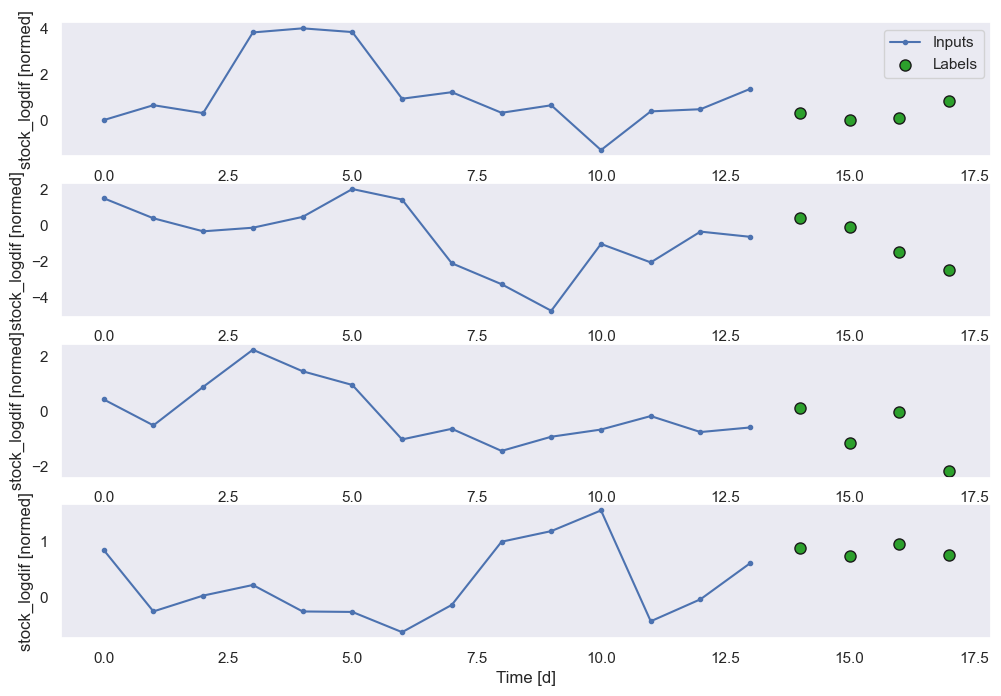

In [34]:
wide_window.plot()

In [35]:
def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.utils.timeseries_dataset_from_array(
          data=data,
          targets=None,
          sequence_length=self.total_window_size,
          sequence_stride=1,
          shuffle=True,
          batch_size=32,)

    ds = ds.map(self.split_window)

    return ds

In [36]:
WindowGenerator.make_dataset = make_dataset

In [37]:
@property
def train(self):
    return self.make_dataset(self.train_df)

@property
def val(self):
    return self.make_dataset(self.val_df)

@property
def test(self):
    return self.make_dataset(self.test_df)

@property
def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example', None)
    if result is None:
        # No example batch was found, so get one from the `.train` dataset
        result = next(iter(self.train))
        # And cache it for next time
        self._example = result
    return result

In [38]:
WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

### Modeling

In [39]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

    model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

    history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
    return history

In [40]:
multi_val_performance = {}
multi_performance = {}

<b> Linear

4/4 [==============================] - 0s 3ms/step - loss: 1.0511 - mean_absolute_error: 0.8004


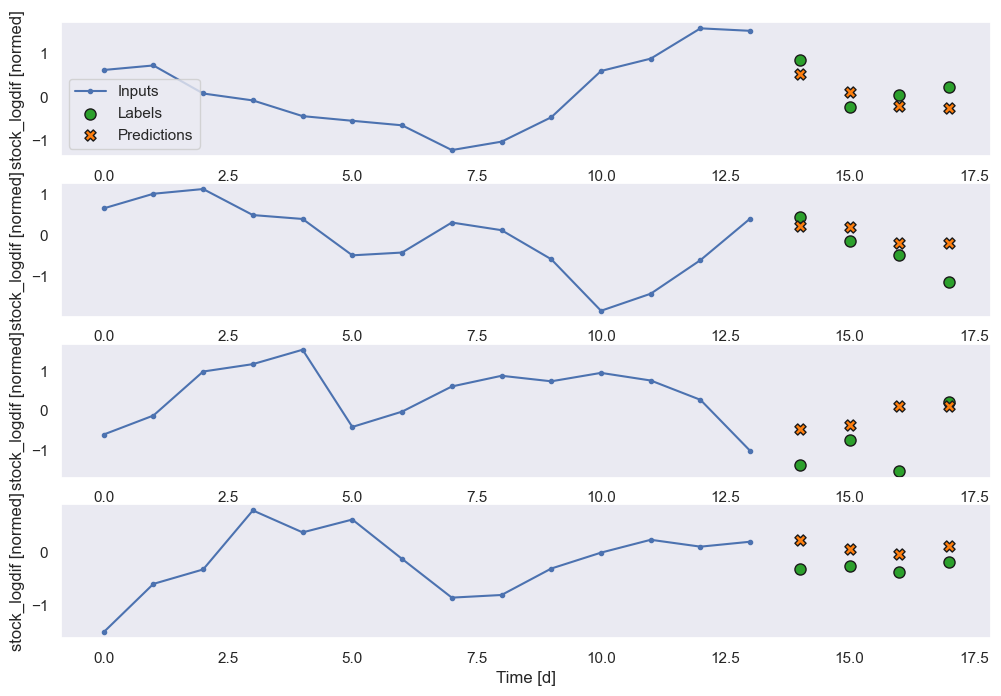

In [42]:
multi_linear_model = tf.keras.Sequential([
    # Take the last time-step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_linear_model, wide_window)

IPython.display.clear_output()
multi_val_performance['Linear'] = multi_linear_model.evaluate(wide_window.val)
multi_performance['Linear'] = multi_linear_model.evaluate(wide_window.test, verbose=0)
wide_window.plot(multi_linear_model)

<b> Dense

4/4 [==============================] - 0s 3ms/step - loss: 1.0257 - mean_absolute_error: 0.7858


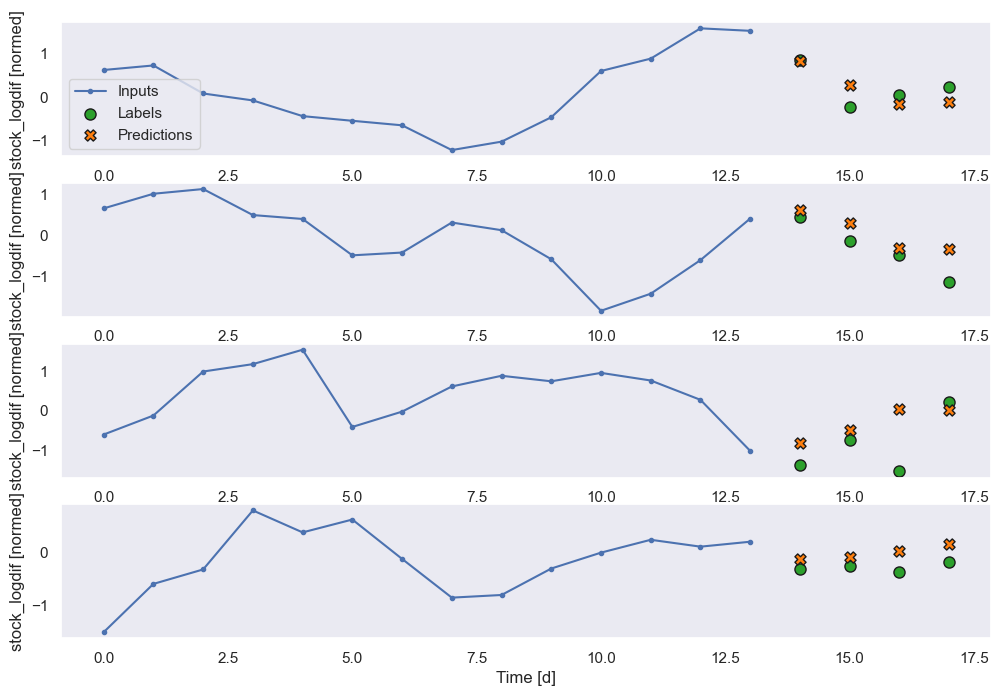

In [43]:
multi_dense_model = tf.keras.Sequential([
    # Take the last time step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(512, activation='relu'),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_dense_model, wide_window)

IPython.display.clear_output()
multi_val_performance['Dense'] = multi_dense_model.evaluate(wide_window.val)
multi_performance['Dense'] = multi_dense_model.evaluate(wide_window.test, verbose=0)
wide_window.plot(multi_dense_model)

<b> convolutional

4/4 [==============================] - 0s 4ms/step - loss: 1.0806 - mean_absolute_error: 0.8077


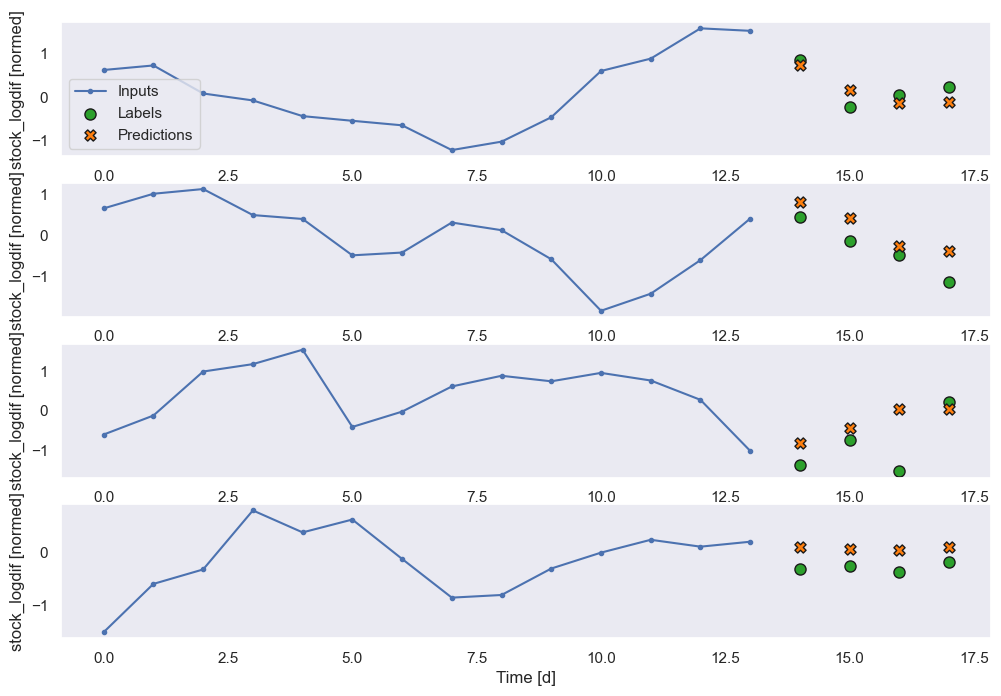

In [44]:
CONV_WIDTH = 3
multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_conv_model, wide_window)

IPython.display.clear_output()

multi_val_performance['Conv'] = multi_conv_model.evaluate(wide_window.val)
multi_performance['Conv'] = multi_conv_model.evaluate(wide_window.test, verbose=0)
wide_window.plot(multi_conv_model)

<b> RNN: LSTM

4/4 [==============================] - 0s 4ms/step - loss: 1.1332 - mean_absolute_error: 0.8412


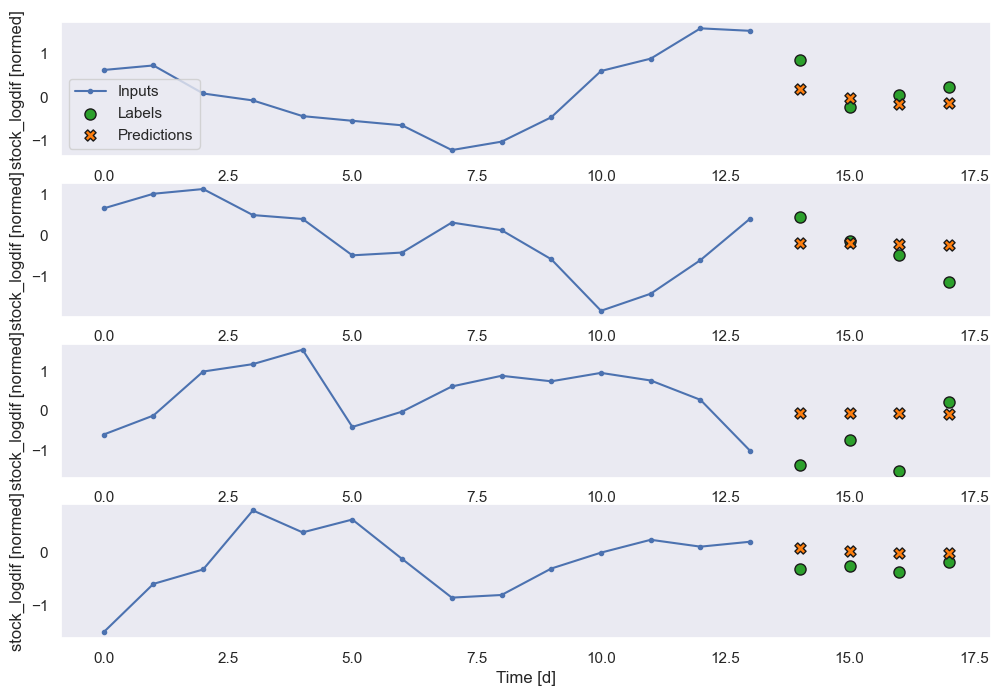

In [45]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, wide_window)

IPython.display.clear_output()

multi_val_performance['LSTM'] = multi_lstm_model.evaluate(wide_window.val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(wide_window.test, verbose=0)
wide_window.plot(multi_lstm_model)

<b> Atoregresive LSTM

In [46]:
class FeedBack(tf.keras.Model):
    def __init__(self, units, out_steps):
        super().__init__()
        self.out_steps = out_steps
        self.units = units
        self.lstm_cell = tf.keras.layers.LSTMCell(units)
        # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
        self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
        self.dense = tf.keras.layers.Dense(num_features)

In [47]:
feedback_model = FeedBack(units=32, out_steps=OUT_STEPS)

In [48]:
def warmup(self, inputs):
    # inputs.shape => (batch, time, features)
    # x.shape => (batch, lstm_units)
    x, *state = self.lstm_rnn(inputs)

    # predictions.shape => (batch, features)
    prediction = self.dense(x)
    return prediction, state

In [49]:
FeedBack.warmup = warmup

In [50]:
prediction, state = feedback_model.warmup(wide_window.example[0])

In [51]:
def call(self, inputs, training=None):
    # Use a TensorArray to capture dynamically unrolled outputs.
    predictions = []
    # Initialize the LSTM state.
    prediction, state = self.warmup(inputs)

    # Insert the first prediction.
    predictions.append(prediction)

    # Run the rest of the prediction steps.
    for n in range(1, self.out_steps):
        # Use the last prediction as input.
        x = prediction
        # Execute one lstm step.
        x, state = self.lstm_cell(x, states=state,
                                  training=training)
        # Convert the lstm output to a prediction.
        prediction = self.dense(x)
        # Add the prediction to the output.
        predictions.append(prediction)

    # predictions.shape => (time, batch, features)
    predictions = tf.stack(predictions)
    # predictions.shape => (batch, time, features)
    predictions = tf.transpose(predictions, [1, 0, 2])
    
    return predictions

FeedBack.call = call

In [52]:
print('Output shape (batch, time, features): ', feedback_model(wide_window.example[0]).shape)

Output shape (batch, time, features):  (32, 4, 11)


4/4 [==============================] - 0s 5ms/step - loss: 1.1428 - mean_absolute_error: 0.8462


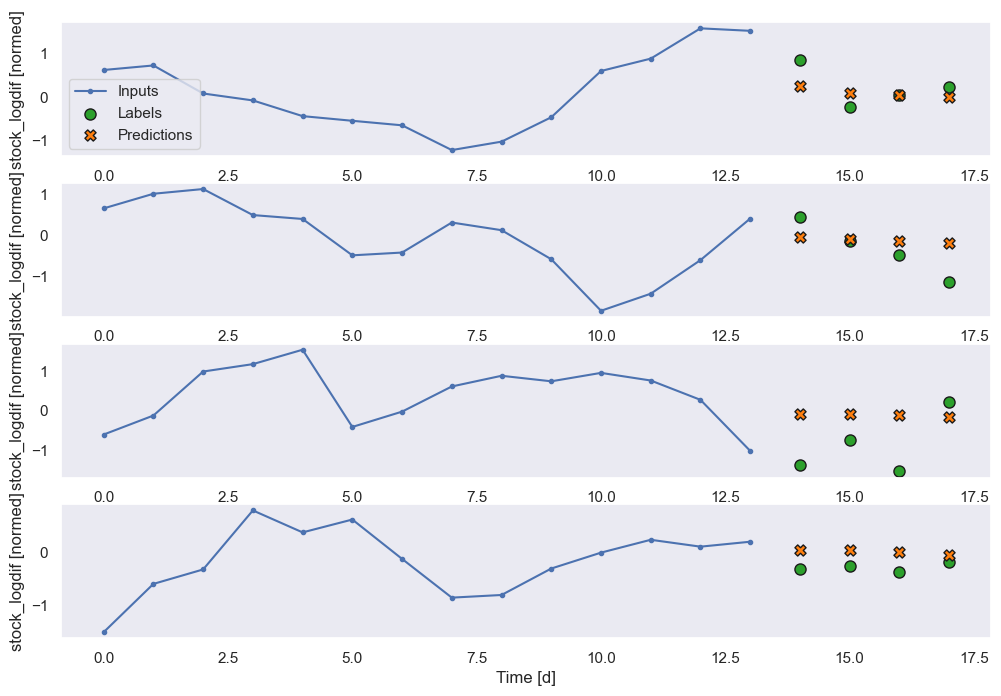

In [53]:
history = compile_and_fit(feedback_model, wide_window)

IPython.display.clear_output()

multi_val_performance['AR LSTM'] = feedback_model.evaluate(wide_window.val)
multi_performance['AR LSTM'] = feedback_model.evaluate(wide_window.test, verbose=0)
wide_window.plot(feedback_model)

<b> miguel model

In [ ]:
CONV_WIDTH = 3
multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

In [88]:
input_shape = [14,11,1]

miguel_model = tf.keras.Sequential([
    tf.keras.Input(input_shape),
    tf.keras.layers.Conv1D(100, activation='relu', kernel_size=(CONV_WIDTH)),
    tf.keras.layers.Conv1D(100, activation='relu', kernel_size=(CONV_WIDTH)),
    tf.keras.layers.Dense(OUT_STEPS*num_features,kernel_initializer=tf.initializers.zeros()),
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

ValueError: Exception encountered when calling layer "reshape_18" (type Reshape).

total size of new array must be unchanged, input_shape = [14, 7, 44], output_shape = [4, 11]

Call arguments received by layer "reshape_18" (type Reshape):
  • inputs=tf.Tensor(shape=(None, 14, 7, 44), dtype=float32)

In [ ]:
history = compile_and_fit(miguel_model, wide_window)

IPython.display.clear_output()

multi_val_performance['miguel_model'] = miguel_model.evaluate(wide_window.val)
multi_performance['miguel_model'] = miguel_model.evaluate(wide_window.test, verbose=0)
wide_window.plot(miguel_model)

In [76]:
a = wide_window.train.take(1)
for x,y in a:
    x= x.numpy()
    y=y.numpy()

In [77]:
x.shape

(32, 14, 11)

<b> Model error

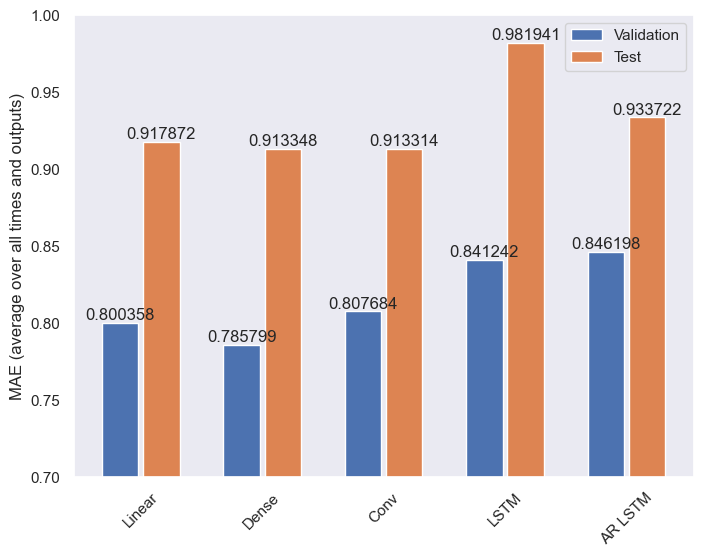

In [54]:
x = np.arange(len(multi_performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = multi_lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in multi_val_performance.values()]
test_mae = [v[metric_index] for v in multi_performance.values()]

fig, ax = plt.subplots()

p1 = ax.bar(x - 0.17, val_mae, width, label='Validation')
p2 = ax.bar(x + 0.17, test_mae, width, label='Test')

ax.set_xticks(ticks=x, labels=multi_performance.keys(),
           rotation=45)
ax.set_ylabel(f'MAE (average over all times and outputs)')
ax.bar_label(p1, label_type='edge')
ax.bar_label(p2, label_type='edge')
ax.set_ylim(0.7, 1)
_ = plt.legend()

### Hyper parameter tunning

In [78]:
def objective(trial):
    
    CONV_WIDTH = 3
    patience=2
    MAX_EPOCHS = 20
    
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]))
    num_conv_layers = trial.suggest_int('num_conv_layers', 1, 1)  #### check why error
    for i in range(num_conv_layers):
        
        model.add(
            tf.keras.layers.Conv1D(
                filters = trial.suggest_categorical('filters_{}'.format(i), [100, 250, 350]),
                activation = trial.suggest_categorical('activation_{}'.format(i), ['relu', 'tanh']),
                kernel_size=(CONV_WIDTH)
            )
        )
             
    num_dense_layers = trial.suggest_int('num_dense_layers', 1, 3) 
    for i in range(num_dense_layers):
        
        model.add(
            tf.keras.layers.Dense(
                units = OUT_STEPS*num_features, # OUT_STEPS*num_features,
                kernel_initializer = tf.initializers.zeros(),
                activation = trial.suggest_categorical('activation_{}'.format(i), ['relu', 'tanh'])
            )    
        )
    
    model.add(tf.keras.layers.Reshape([OUT_STEPS, num_features]))   
    
    optimizer_name =trial.suggest_categorical('optimizer_name', ['Adam', 'RMSprop'])
    if optimizer_name == 'Adam':
        optimizer = tf.keras.optimizers.Adam(learning_rate=trial.suggest_float('learning_rate',  1e-6, 1e-2))
    else:
        optimizer = tf.keras.optimizers.RMSprop(
            learning_rate=trial.suggest_float('learning_rate',  1e-6, 1e-2),
            momentum=trial.suggest_float('momentum',  0.1, 0.9),
        )
    
    model.compile(
        loss=tf.losses.MeanSquaredError(),
        optimizer= optimizer,
        metrics=[tf.metrics.MeanAbsoluteError()]
    )
    
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')
    
    history = model.fit(
        wide_window.train,
        epochs=MAX_EPOCHS,
        validation_data=wide_window.val,
        callbacks=[early_stopping]
    )
    
    IPython.display.clear_output()
    
    error = model.evaluate(wide_window.test)[1]  
    global best_error
    
    if error < best_error:
        model.save(path_best_model)
        best_accuracy = error

    del model
    return error
    

In [79]:
study_name = f"{save_model_path}/cnn_study"  # unique identifier of the study.
storage_name = "sqlite:///{}.db".format(study_name)

In [80]:
study = optuna.create_study(
    direction='minimize',
    study_name=study_name,
    storage=storage_name,
    load_if_exists=True,
)

study.optimize(objective, n_trials=5)

3/3 [==============================] - 0s 4ms/step - loss: 1.5041 - mean_absolute_error: 0.9580


[I 2023-01-20 18:57:09,906] Trial 66 finished with value: 0.9580413103103638 and parameters: {'num_conv_layers': 1, 'filters_0': 250, 'activation_0': 'relu', 'num_dense_layers': 1, 'optimizer_name': 'Adam', 'learning_rate': 0.004121152909630359}. Best is trial 25 with value: 0.8841513991355896.


In [81]:
study.best_params

{'activation': 'relu',
 'filters': 250,
 'learning_rate': 0.004085198314006357,
 'num_conv_layers': 1,
 'num_dense_layers': 1,
 'optimizer_name': 'Adam'}

In [82]:
study.best_value

0.8841513991355896

Text(0, 0.5, 'Error')

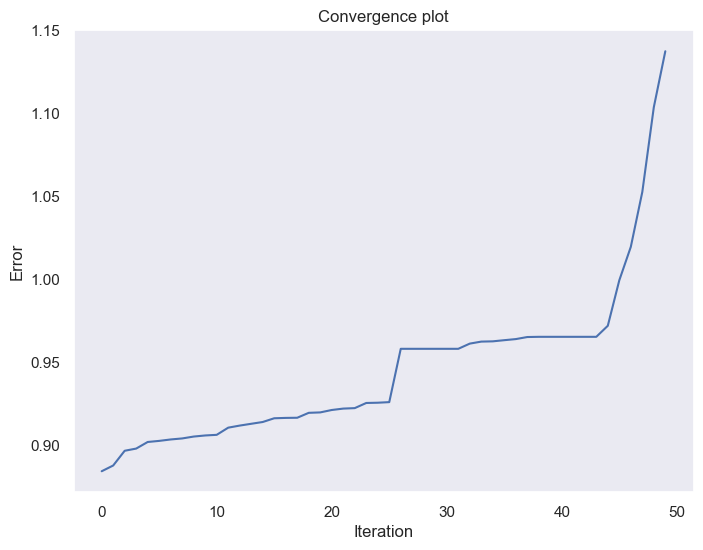

In [83]:
results = study.trials_dataframe()

results['value'].sort_values().reset_index(drop=True).plot()
plt.title('Convergence plot')
plt.xlabel('Iteration')
plt.ylabel('Error')

In [84]:
best_model = tf.keras.models.load_model(path_best_model)

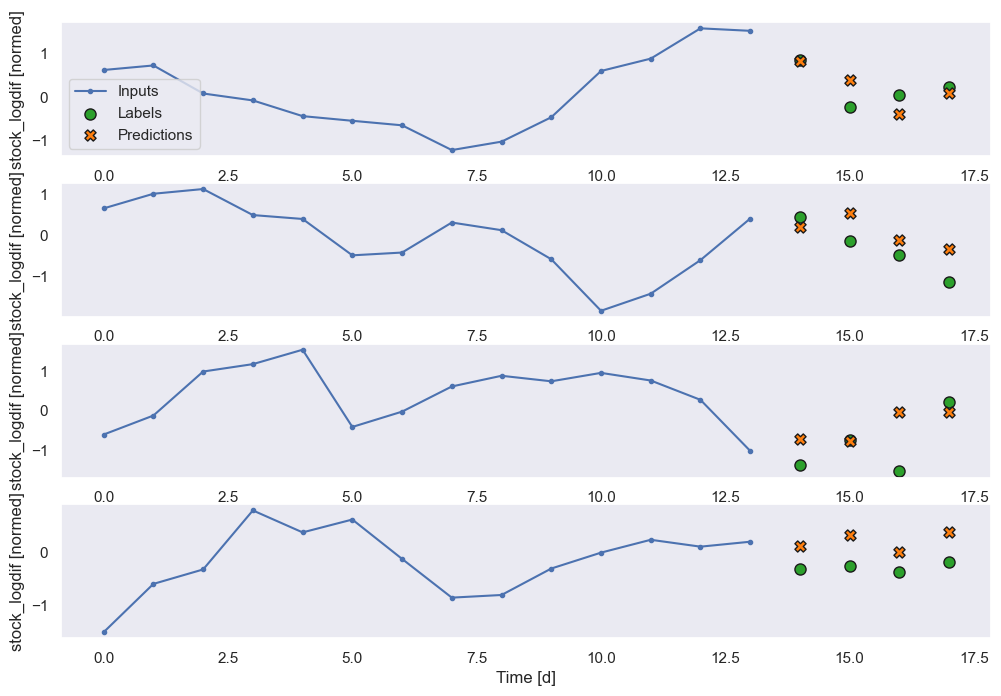

In [85]:
wide_window.plot(best_model)

In [63]:
def plot_test(self, model, plot_col='stock_logdif', max_subplots = 4, take_ =1):
    
    sample_test = self.test.take(take_)
    for input_,label in sample_test:
        numpy_input = input_.numpy()
        numpy_labels = label.numpy()
        
    plt.figure(figsize=(12, 8))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(numpy_input))
    
    for n in range(max_n):
        plt.subplot(max_n, 1, n+1)
        plt.ylabel(f'{plot_col} [normed]')
        plt.plot(self.input_indices, numpy_input[n, :, plot_col_index],
                 label='Inputs', marker='.', zorder=-10)
        
        if self.label_columns:
            label_col_index = self.label_columns_indices.get(plot_col, None)
        else:
            label_col_index = plot_col_index

        if label_col_index is None:
            continue
            
        plt.scatter(self.label_indices, numpy_labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
        
        predictions = model(numpy_input)
        plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                        marker='X', edgecolors='k', label='Predictions',
                        c='#ff7f0e', s=64)
        if n == 0:
            plt.legend()

    plt.xlabel('Time [d]')

In [64]:
WindowGenerator.plot_test = plot_test

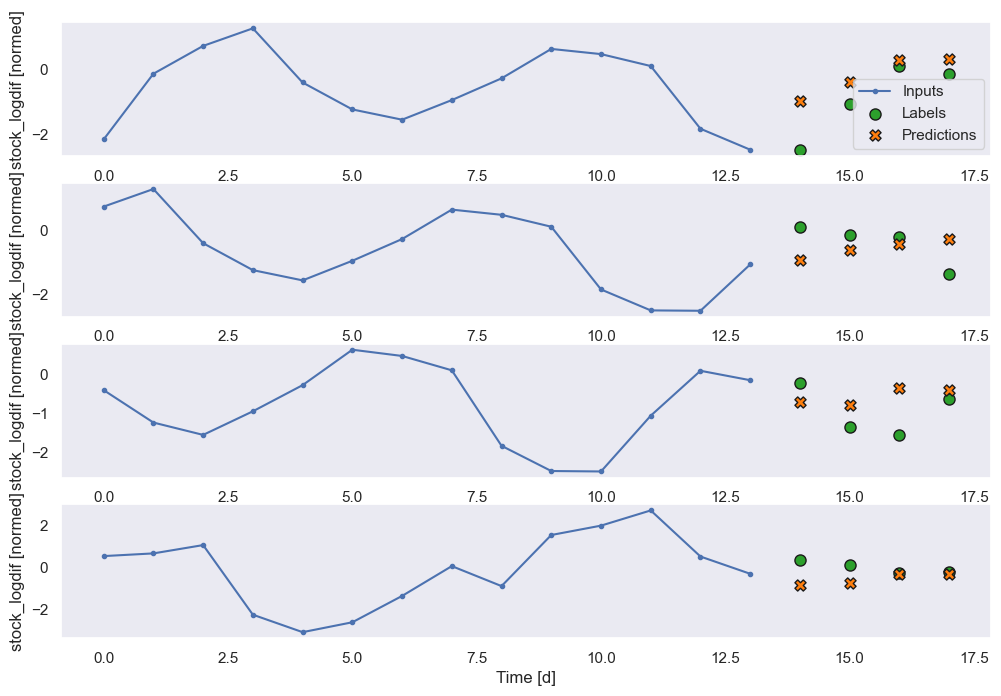

In [65]:
wide_window.plot_test(best_model)

### Expected Return and Price

In [66]:
def expected_return_plot(self,model, plot = True, train_mean = train_mean , train_std = train_std , plot_col='stock_logdif'):

    data_ = self.total_data[-self.input_width:]
    data_ = (data_  - train_mean) / train_std
    data_ = data_.values
    data_ = data_.reshape((1,data_.shape[0],data_.shape[1]))
    plot_col_index = self.column_indices[plot_col]
    
    if self.label_columns:
        label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
        label_col_index = plot_col_index
        
    if plot:
        plt.figure(figsize=(8, 4))
        plt.ylabel(f'{plot_col} [normed]')
        plt.plot(self.input_indices, data_[0, :, plot_col_index],
                     label='Inputs', marker='.', zorder=-10)

        predictions = model(data_)
        plt.scatter(self.label_indices, predictions[0, :, label_col_index],
                        marker='X', edgecolors='k', label='Predictions',
                        c='#ff7f0e', s=64)

        plt.xlabel('Time [d]')
    return predictions

In [67]:
WindowGenerator.expected_return_plot = expected_return_plot

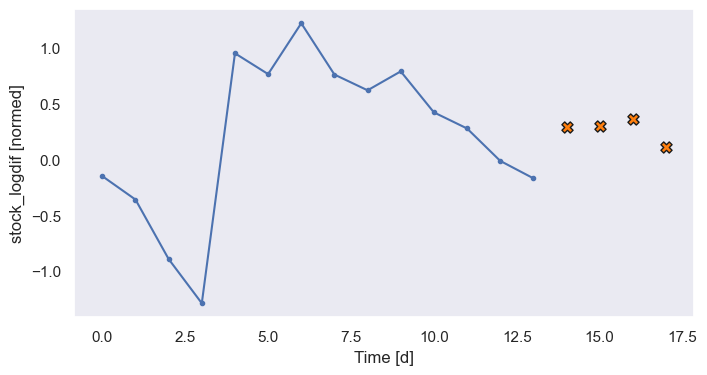

In [68]:
predictions = wide_window.expected_return_plot(plot_col='stock_logdif', model = best_model)

In [69]:
def get_futur_prices(self,predictions,steps_futur, stock_code, plot = True, plot_col = 'stock_logdif', n_days = 14):
    
    index = self.label_columns_indices.get(plot_col, None)

    prep_predictions = {
        'Date': [ self.raw_stock['Date'].max() + relativedelta(days = i+1) for i in  range(OUT_STEPS)],
        'stock_price': [0]*steps_futur,
        'stock_stv': [0]*steps_futur,
        'stock_logdif': list(predictions[0,:,index].numpy()) 
    }
    prep_predictions = pd.DataFrame(prep_predictions)
    prep_predictions['stock_logdif'] = prep_predictions['stock_logdif'] * train_std[plot_col] + train_mean[plot_col]
    
    past_prices = self.raw_stock[-lag_days:]['stock_price'].values
    exp_returns = prep_predictions['stock_logdif'].values
    
    expt_price = list()

    for i in range(steps_futur):
        if i < len(past_prices):
            pred = np.exp(np.log(past_prices[i]) + exp_returns[i])
            expt_price.append(pred)
        else:
            j = i - len(past_prices)
            pred = np.exp(np.log(expt_price[j]) + exp_returns[i])
            expt_price.append(pred)
            
    prep_predictions['stock_price'] = expt_price
    prep_predictions['Type'] = 'Forecast'
    prep_predictions['StockCode'] = stock_code
    
    some_history = self.raw_stock[-(lag_days+n_days):].copy()
    some_history['Type'] = 'History'
    some_history['StockCode'] = stock_code
    
    final_ = pd.concat([some_history, prep_predictions]).reset_index(drop = True)
    final_ = final_[['Date','stock_price','Type','StockCode']]
    final_ = final_[-(steps_futur+4):]
    
    if plot:
        plt.figure(figsize=(10, 4))
        plt.ylabel(f'stock price')
        plt.plot(some_history.Date, some_history.stock_price, label='Inputs', marker='.', zorder=-10)
        plt.scatter(prep_predictions.Date, prep_predictions.stock_price,marker='X', edgecolors='k', label='Predictions',c='#ff7f0e', s=64)
        plt.xlabel('date')
    
    return final_

In [70]:
WindowGenerator.get_futur_prices = get_futur_prices

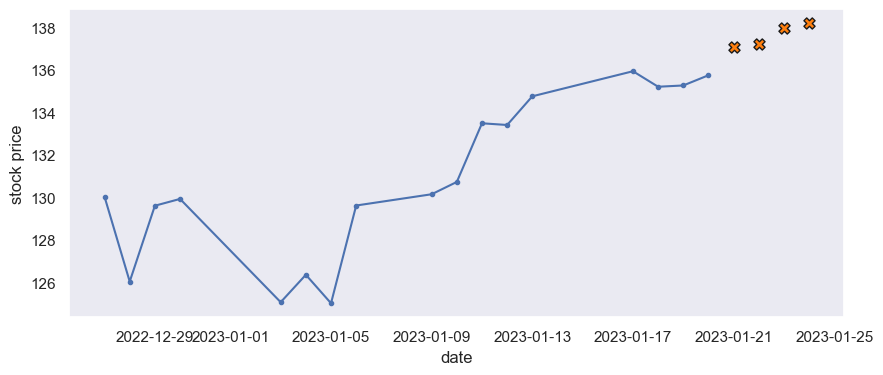

In [71]:
final_result = wide_window.get_futur_prices(predictions= predictions ,steps_futur = OUT_STEPS, stock_code= stock_code_name)

### Saving Results

In [72]:
final_result.to_csv(f'{save_output_path}/{today_str}-{stock_code_name}-predictions.csv')